In [ ]:
# Cell 1: Reproducing BYOL on CIFAR-10 with Detailed Print Statements

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import copy
import time

print("Starting Cell 1: Fully reproduce BYOL on CIFAR-10...")

# Define a transform that will generate two differently augmented views.
class TwoCropsTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        return [self.base_transform(x), self.base_transform(x)]

# Define our data augmentation pipeline (similar to that used in BYOL).
base_augmentation = transforms.Compose([
    transforms.RandomResizedCrop(size=32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2023, 0.1994, 0.2010))
])
# Wrap the transform to get two augmented copies.
transform_train = TwoCropsTransform(base_augmentation)

# Load the CIFAR-10 training dataset.
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                             train=True,
                                             download=True,
                                             transform=transform_train)
print(f"Loaded CIFAR-10 training dataset with {len(train_dataset)} samples.")
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

# --- Model Components ---

# MLP definition for both the projector and predictor.
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

# Modify the ResNet-18 to output a feature vector (remove the final FC layer).
class ResNet18Feature(nn.Module):
    def __init__(self):
        super(ResNet18Feature, self).__init__()
        self.resnet = resnet18(pretrained=False)
        # Remove the final classification layer: take all layers except the last fully connected.
        self.features = nn.Sequential(*list(self.resnet.children())[:-1])
        self.fc_dim = 512  # output dimension for resnet18

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

# Define the BYOL model which assembles encoder, projector, and predictor.
class BYOL(nn.Module):
    def __init__(self, base_encoder):
        super(BYOL, self).__init__()
        self.encoder = base_encoder
        self.projector = MLP(in_dim=base_encoder.fc_dim, hidden_dim=256, out_dim=256)
        self.predictor = MLP(in_dim=256, hidden_dim=256, out_dim=256)

    def forward(self, x):
        features = self.encoder(x)
        proj = self.projector(features)
        pred = self.predictor(proj)
        return features, proj, pred

# Setup devices and instantiate our online and target networks.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Online network instantiation.
online_encoder = ResNet18Feature().to(device)
online_model = BYOL(online_encoder).to(device)
print("Initialized online BYOL model.")

# Target network: a deep copy of the online components (without the predictor).
target_encoder = copy.deepcopy(online_encoder).to(device)
target_projector = copy.deepcopy(online_model.projector).to(device)
target_encoder.eval()
target_projector.eval()
print("Initialized target encoder and projector (set to eval mode).")

# Optimizer for the online network (including encoder, projector, and predictor).
optimizer = optim.SGD(online_model.parameters(), lr=0.03, momentum=0.9, weight_decay=5e-4)
print("Optimizer initialized for online network.")

# Function to update target network parameters using exponential moving average (EMA).
def update_moving_average(online_net, target_net, momentum):
    for param_o, param_t in zip(online_net.parameters(), target_net.parameters()):
        param_t.data = param_t.data * momentum + param_o.data * (1.0 - momentum)

# --- Training Loop for BYOL ---
epochs = 10  # (For demonstration purposes; increase this for real experiments)
ema_momentum = 0.996  # Momentum coefficient for target updates

print("Starting BYOL training...")
for epoch in range(epochs):
    online_model.train()
    running_loss = 0.0
    start_time = time.time()

    for batch_idx, (images, _) in enumerate(train_loader):
        # Each 'images' is a list of two augmented views.
        view1, view2 = images[0].to(device), images[1].to(device)
        optimizer.zero_grad()

        # Debug: Print shapes of input views.
        if batch_idx == 0:
            print(f"Epoch {epoch+1}: First batch view1 shape: {view1.shape}, view2 shape: {view2.shape}")

        # First branch: online network processes view1.
        _, proj1, pred1 = online_model(view1)
        # Target network processes view2 (no gradients).
        with torch.no_grad():
            feat2 = target_encoder(view2)
            proj2 = target_projector(feat2)

        # Normalize before computing mean-squared error.
        pred1_norm = F.normalize(pred1, dim=1)
        proj2_norm = F.normalize(proj2, dim=1)
        loss1 = F.mse_loss(pred1_norm, proj2_norm)

        # Second branch: swap views.
        _, proj2_online, pred2 = online_model(view2)
        with torch.no_grad():
            feat1 = target_encoder(view1)
            proj1_target = target_projector(feat1)
        pred2_norm = F.normalize(pred2, dim=1)
        proj1_target_norm = F.normalize(proj1_target, dim=1)
        loss2 = F.mse_loss(pred2_norm, proj1_target_norm)

        loss = loss1 + loss2
        loss.backward()
        optimizer.step()

        # Update target network weights with EMA.
        update_moving_average(online_encoder, target_encoder, ema_momentum)
        update_moving_average(online_model.projector, target_projector, ema_momentum)

        running_loss += loss.item() * view1.size(0)

        # Print progress every 50 batches.
        if (batch_idx + 1) % 50 == 0:
            print(f"Epoch {epoch+1} Batch {batch_idx+1}: Loss1={loss1.item():.4f}, Loss2={loss2.item():.4f}")

    epoch_loss = running_loss / len(train_loader.dataset)
    elapsed = time.time() - start_time
    print(f"Completed Epoch {epoch+1}: Avg Loss: {epoch_loss:.4f}, Time: {elapsed:.2f}s")

print("BYOL training finished on CIFAR-10.")


Starting Cell 1: Fully reproduce BYOL on CIFAR-10...
Loaded CIFAR-10 training dataset with 50000 samples.
Using device: cuda
Initialized online BYOL model.
Initialized target encoder and projector (set to eval mode).
Optimizer initialized for online network.
Starting BYOL training...
Epoch 1: First batch view1 shape: torch.Size([128, 3, 32, 32]), view2 shape: torch.Size([128, 3, 32, 32])
Epoch 1 Batch 50: Loss1=0.0030, Loss2=0.0031
Epoch 1 Batch 100: Loss1=0.0015, Loss2=0.0015
Epoch 1 Batch 150: Loss1=0.0010, Loss2=0.0010
Epoch 1 Batch 200: Loss1=0.0007, Loss2=0.0007
Epoch 1 Batch 250: Loss1=0.0006, Loss2=0.0006
Epoch 1 Batch 300: Loss1=0.0005, Loss2=0.0005
Epoch 1 Batch 350: Loss1=0.0005, Loss2=0.0005
Completed Epoch 1: Avg Loss: 0.0028, Time: 83.94s
Epoch 2: First batch view1 shape: torch.Size([128, 3, 32, 32]), view2 shape: torch.Size([128, 3, 32, 32])
Epoch 2 Batch 50: Loss1=0.0004, Loss2=0.0004
Epoch 2 Batch 100: Loss1=0.0003, Loss2=0.0004
Epoch 2 Batch 150: Loss1=0.0003, Loss2=0.

In [ ]:
# Cell 2: Semi-Supervised BYOL with a Small Fraction of Labeled Data including detailed print statements

import numpy as np
from torch.utils.data import Subset, DataLoader

print("\nStarting Cell 2: Semi-Supervised BYOL...")

# Define a simple classifier head to attach to our encoder.
class ClassifierHead(nn.Module):
    def __init__(self, in_dim, num_classes=10):
        super(ClassifierHead, self).__init__()
        self.fc = nn.Linear(in_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

# We reuse the previously defined ResNet18Feature and BYOL model.
# Here we add a classification head to the online encoder.
class SemiSupervisedBYOL(nn.Module):
    def __init__(self, base_encoder, num_classes=10):
        super(SemiSupervisedBYOL, self).__init__()
        self.encoder = base_encoder  # shared encoder
        self.projector = MLP(in_dim=base_encoder.fc_dim, hidden_dim=256, out_dim=256)
        self.predictor = MLP(in_dim=256, hidden_dim=256, out_dim=256)
        # Classification head for supervised learning.
        self.classifier = ClassifierHead(in_dim=base_encoder.fc_dim, num_classes=num_classes)

    def forward(self, x):
        features = self.encoder(x)
        proj = self.projector(features)
        pred = self.predictor(proj)
        logits = self.classifier(features)
        return features, proj, pred, logits

# Create a labeled split (10% of CIFAR-10 training data).
all_indices = np.arange(len(train_dataset))
np.random.seed(42)  # for reproducibility
labeled_indices = np.random.choice(all_indices, size=int(0.1 * len(train_dataset)), replace=False)
unlabeled_indices = np.setdiff1d(all_indices, labeled_indices)
print(f"Total samples: {len(train_dataset)}, Labeled: {len(labeled_indices)}, Unlabeled: {len(unlabeled_indices)}")

# For the labeled dataset we will use a standard transform for classification (without double augmentation).
transform_labeled = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2023, 0.1994, 0.2010))
])
# Create labeled and unlabeled subsets.
labeled_dataset = Subset(torchvision.datasets.CIFAR10(root='./data', train=True,
                                                      download=False,
                                                      transform=transform_labeled),
                         labeled_indices)
# Unlabeled dataset still uses two-crop transform.
unlabeled_dataset = Subset(train_dataset, unlabeled_indices)
print("Created labeled and unlabeled datasets.")

# Define dataloaders for both.
labeled_loader = DataLoader(labeled_dataset, batch_size=64, shuffle=True, num_workers=2)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=128, shuffle=True, num_workers=2)

# Instantiate the semi-supervised BYOL model.
base_encoder_ss = ResNet18Feature().to(device)
semi_supervised_model = SemiSupervisedBYOL(base_encoder_ss).to(device)
print("Initialized semi-supervised BYOL model with classifier head.")

# Copy target network components for the unsupervised loss (EMA updates only on encoder and projector).
target_encoder_ss = copy.deepcopy(base_encoder_ss).to(device)
target_projector_ss = copy.deepcopy(semi_supervised_model.projector).to(device)
target_encoder_ss.eval()
target_projector_ss.eval()
print("Initialized target network for semi-supervised branch.")

# Optimizer covers all parameters (encoder, projector, predictor, and classification head).
optimizer_ss = optim.SGD(semi_supervised_model.parameters(), lr=0.03, momentum=0.9, weight_decay=5e-4)
criterion_supervised = nn.CrossEntropyLoss()
lambda_sup = 1.0  # Weighting coefficient for the supervised loss

# Training loop for semi-supervised learning.
epochs_ss = 10
print("Starting semi-supervised training...")
for epoch in range(epochs_ss):
    semi_supervised_model.train()
    running_loss = 0.0
    running_sup_loss = 0.0
    start_time = time.time()

    unlabeled_iter = iter(unlabeled_loader)
    labeled_iter = iter(labeled_loader)

    num_iterations = len(unlabeled_loader)
    print(f"Epoch {epoch+1}/{epochs_ss} with {num_iterations} iterations.")

    for iter_idx in range(num_iterations):
        # --- Unsupervised BYOL branch on unlabeled data ---
        try:
            images_unlab, _ = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(unlabeled_loader)
            images_unlab, _ = next(unlabeled_iter)
        view1, view2 = images_unlab[0].to(device), images_unlab[1].to(device)

        # Forward pass for unsupervised branch.
        _, proj1, pred1, _ = semi_supervised_model(view1)
        with torch.no_grad():
            feat2 = target_encoder_ss(view2)
            proj2 = target_projector_ss(feat2)
        loss1 = F.mse_loss(F.normalize(pred1, dim=1), F.normalize(proj2, dim=1))

        _, proj2_online, pred2, _ = semi_supervised_model(view2)
        with torch.no_grad():
            feat1 = target_encoder_ss(view1)
            proj1_target = target_projector_ss(feat1)
        loss2 = F.mse_loss(F.normalize(pred2, dim=1), F.normalize(proj1_target, dim=1))
        loss_unsupervised = loss1 + loss2

        # --- Supervised branch on labeled data ---
        try:
            images_lab, labels_lab = next(labeled_iter)
        except StopIteration:
            labeled_iter = iter(labeled_loader)
            images_lab, labels_lab = next(labeled_iter)
        images_lab = images_lab.to(device)
        labels_lab = labels_lab.to(device)
        _, _, _, logits = semi_supervised_model(images_lab)
        loss_supervised = criterion_supervised(logits, labels_lab)

        # Total loss: weighted sum of unsupervised and supervised parts.
        total_loss = loss_unsupervised + lambda_sup * loss_supervised

        optimizer_ss.zero_grad()
        total_loss.backward()
        optimizer_ss.step()

        # EMA update for target network components.
        update_moving_average(semi_supervised_model.encoder, target_encoder_ss, ema_momentum)
        update_moving_average(semi_supervised_model.projector, target_projector_ss, ema_momentum)

        running_loss += total_loss.item()
        running_sup_loss += loss_supervised.item()

        # Detailed print on every 20 iterations.
        if (iter_idx + 1) % 20 == 0:
            print(f"Epoch {epoch+1} Iteration {iter_idx+1}: "
                  f"Unsup Loss={loss_unsupervised.item():.4f}, Sup Loss={loss_supervised.item():.4f}, Total Loss={total_loss.item():.4f}")

    avg_loss = running_loss / num_iterations
    avg_sup_loss = running_sup_loss / num_iterations
    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1} complete: Avg Total Loss: {avg_loss:.4f}, Avg Sup Loss: {avg_sup_loss:.4f}, Time: {elapsed:.2f}s")

print("Semi-supervised BYOL training finished.")



Starting Cell 2: Semi-Supervised BYOL...
Total samples: 50000, Labeled: 5000, Unlabeled: 45000
Created labeled and unlabeled datasets.
Initialized semi-supervised BYOL model with classifier head.
Initialized target network for semi-supervised branch.
Starting semi-supervised training...
Epoch 1/10 with 352 iterations.
Epoch 1 Iteration 20: Unsup Loss=0.0126, Sup Loss=2.7380, Total Loss=2.7507
Epoch 1 Iteration 40: Unsup Loss=0.0087, Sup Loss=3.0002, Total Loss=3.0089
Epoch 1 Iteration 60: Unsup Loss=0.0065, Sup Loss=2.7076, Total Loss=2.7141
Epoch 1 Iteration 80: Unsup Loss=0.0048, Sup Loss=2.4383, Total Loss=2.4431
Epoch 1 Iteration 100: Unsup Loss=0.0035, Sup Loss=2.4945, Total Loss=2.4981
Epoch 1 Iteration 120: Unsup Loss=0.0027, Sup Loss=2.2127, Total Loss=2.2154
Epoch 1 Iteration 140: Unsup Loss=0.0022, Sup Loss=2.0711, Total Loss=2.0733
Epoch 1 Iteration 160: Unsup Loss=0.0018, Sup Loss=2.6915, Total Loss=2.6933
Epoch 1 Iteration 180: Unsup Loss=0.0016, Sup Loss=2.1905, Total Lo

In [ ]:
# Cell 3: Comparison with SimCLR and MoCo (Modified with dynamic NT-Xent loss)

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import copy
import time

print("\nStarting Cell 3: Comparison with SimCLR and MoCo...")

# Modified NT-Xent Loss (with dynamic batch size)
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")

    def forward(self, z):
        # Normalize the embeddings.
        z = F.normalize(z, dim=1)
        N = z.size(0)  # Total number of embeddings (should be 2 * batch_size)
        batch_size = N // 2

        # Compute similarity matrix.
        similarity_matrix = torch.matmul(z, z.T) / self.temperature

        # Extract positive pairs by taking diagonals offset by batch_size.
        positives = torch.cat([
            torch.diag(similarity_matrix, batch_size),
            torch.diag(similarity_matrix, -batch_size)
        ]).view(N, 1)

        # Create a mask to remove self-similarities.
        mask = torch.ones((N, N), device=z.device) - torch.eye(N, device=z.device)
        mask = mask.bool()

        negatives = similarity_matrix[mask].view(N, -1)

        # The first logit in each row is the positive example.
        labels = torch.zeros(N, dtype=torch.long, device=z.device)

        # Concatenate positive and negative logits.
        logits = torch.cat([positives, negatives], dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        return loss

# SimCLR model: uses the same encoder and an added projector.
class SimCLR(nn.Module):
    def __init__(self, base_encoder):
        super(SimCLR, self).__init__()
        self.encoder = base_encoder
        self.projector = MLP(in_dim=base_encoder.fc_dim, hidden_dim=256, out_dim=128)

    def forward(self, x):
        features = self.encoder(x)
        projection = self.projector(features)
        return projection

# Assuming TwoCropsTransform, base_augmentation, ResNet18Feature, and MLP have been defined in earlier cells.
# Data loader for SimCLR uses the same two-crop transform as in BYOL.
simclr_dataset = torchvision.datasets.CIFAR10(root='./data',
                                              train=True,
                                              download=False,
                                              transform=TwoCropsTransform(base_augmentation))
simclr_loader = torch.utils.data.DataLoader(simclr_dataset,
                                            batch_size=128,
                                            shuffle=True,
                                            num_workers=2)
print("SimCLR dataloader created.")

# Instantiate SimCLR model and NT-Xent loss.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
base_encoder_simclr = ResNet18Feature().to(device)
simclr_model = SimCLR(base_encoder_simclr).to(device)
optimizer_simclr = torch.optim.SGD(simclr_model.parameters(), lr=0.03, momentum=0.9, weight_decay=5e-4)
ntxent_loss = NTXentLoss(temperature=0.5)
print("Initialized SimCLR model and NTXent loss.")

# Training loop for SimCLR.
epochs_simclr = 5
print("Starting SimCLR training...")
for epoch in range(epochs_simclr):
    simclr_model.train()
    running_loss = 0.0
    for batch_idx, (images, _) in enumerate(simclr_loader):
        # Concatenate two augmented views: resulting tensor shape [2*B, C, H, W].
        view1, view2 = images[0].to(device), images[1].to(device)
        x = torch.cat([view1, view2], dim=0)
        optimizer_simclr.zero_grad()
        projections = simclr_model(x)
        loss = ntxent_loss(projections)
        loss.backward()
        optimizer_simclr.step()

        running_loss += loss.item() * view1.size(0)
        if (batch_idx + 1) % 50 == 0:
            print(f"SimCLR Epoch {epoch+1}, Batch {batch_idx+1}: Loss = {loss.item():.4f}")
    epoch_loss = running_loss / len(simclr_loader.dataset)
    print(f"SimCLR Epoch {epoch+1} complete: Avg Loss = {epoch_loss:.4f}")
print("SimCLR training finished.")

# --- MoCo Implementation ---
class MoCo(nn.Module):
    def __init__(self, base_encoder, dim=128, K=1024, m=0.999, T=0.07):
        super(MoCo, self).__init__()
        self.K = K  # Queue size.
        self.m = m  # Momentum coefficient.
        self.T = T  # Temperature.
        self.encoder_q = base_encoder
        self.projector_q = MLP(in_dim=base_encoder.fc_dim, hidden_dim=256, out_dim=dim)

        # Create the momentum encoder (key encoder).
        self.encoder_k = copy.deepcopy(base_encoder)
        self.projector_k = copy.deepcopy(self.projector_q)
        for param in self.encoder_k.parameters():
            param.requires_grad = False
        for param in self.projector_k.parameters():
            param.requires_grad = False

        # Initialize the queue.
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = F.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))
        print("MoCo: Queue initialized with shape:", self.queue.shape)

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        # Momentum update for key encoder.
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1.0 - self.m)
        for param_q, param_k in zip(self.projector_q.parameters(), self.projector_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1.0 - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)
        if ptr + batch_size <= self.K:
            self.queue[:, ptr:ptr+batch_size] = keys.T
            self.queue_ptr[0] = (ptr + batch_size) % self.K
        else:
            first_part = self.K - ptr
            self.queue[:, ptr:] = keys[:first_part].T
            self.queue[:, :batch_size-first_part] = keys[first_part:].T
            self.queue_ptr[0] = (batch_size-first_part) % self.K
        print("MoCo: Queue updated; new pointer:", self.queue_ptr.item())

    def forward(self, im_q, im_k):
        # Compute query features.
        q = self.projector_q(self.encoder_q(im_q))  # [B, dim]
        q = F.normalize(q, dim=1)

        # Compute key features.
        with torch.no_grad():
            self._momentum_update_key_encoder()
            k = self.projector_k(self.encoder_k(im_k))  # [B, dim]
            k = F.normalize(k, dim=1)

        # Compute positive and negative logits.
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)  # Positive logits.
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])  # Negative logits.

        logits = torch.cat([l_pos, l_neg], dim=1)
        logits /= self.T

        labels = torch.zeros(logits.shape[0], dtype=torch.long, device=logits.device)

        # Update the queue.
        self._dequeue_and_enqueue(k)
        return logits, labels

# Instantiate MoCo.
base_encoder_moco = ResNet18Feature().to(device)
moco_model = MoCo(base_encoder_moco, dim=128, K=1024, m=0.999, T=0.07).to(device)
optimizer_moco = torch.optim.SGD(list(moco_model.encoder_q.parameters()) +
                                 list(moco_model.projector_q.parameters()),
                                 lr=0.03, momentum=0.9, weight_decay=5e-4)
criterion_moco = nn.CrossEntropyLoss()
print("Initialized MoCo model.")

# Data loader for MoCo uses two-crop transform.
moco_dataset = torchvision.datasets.CIFAR10(root='./data',
                                            train=True,
                                            download=False,
                                            transform=TwoCropsTransform(base_augmentation))
moco_loader = torch.utils.data.DataLoader(moco_dataset,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=2)
print("MoCo dataloader created.")

# Training loop for MoCo.
epochs_moco = 5
print("Starting MoCo training...")
for epoch in range(epochs_moco):
    moco_model.train()
    running_loss = 0.0
    for batch_idx, (images, _) in enumerate(moco_loader):
        im_q, im_k = images[0].to(device), images[1].to(device)
        optimizer_moco.zero_grad()
        logits, labels = moco_model(im_q, im_k)
        loss = criterion_moco(logits, labels)
        loss.backward()
        optimizer_moco.step()
        running_loss += loss.item() * im_q.size(0)
        if (batch_idx + 1) % 50 == 0:
            print(f"MoCo Epoch {epoch+1}, Batch {batch_idx+1}: Loss = {loss.item():.4f}")
    epoch_loss = running_loss / len(moco_loader.dataset)
    print(f"MoCo Epoch {epoch+1} complete: Avg Loss = {epoch_loss:.4f}")
print("MoCo training finished.")

print("Comparison training complete. Detailed logs above provide insights into batch-wise and epoch-wise loss values and updates.")




Starting Cell 3: Comparison with SimCLR and MoCo...
SimCLR dataloader created.
Initialized SimCLR model and NTXent loss.
Starting SimCLR training...
SimCLR Epoch 1, Batch 50: Loss = 4.9764
SimCLR Epoch 1, Batch 100: Loss = 5.0105
SimCLR Epoch 1, Batch 150: Loss = 4.8512
SimCLR Epoch 1, Batch 200: Loss = 4.7819
SimCLR Epoch 1, Batch 250: Loss = 4.7762
SimCLR Epoch 1, Batch 300: Loss = 4.6793
SimCLR Epoch 1, Batch 350: Loss = 4.8703
SimCLR Epoch 1 complete: Avg Loss = 4.8242
SimCLR Epoch 2, Batch 50: Loss = 4.7072
SimCLR Epoch 2, Batch 100: Loss = 4.6860
SimCLR Epoch 2, Batch 150: Loss = 4.6953
SimCLR Epoch 2, Batch 200: Loss = 4.6348
SimCLR Epoch 2, Batch 250: Loss = 4.6426
SimCLR Epoch 2, Batch 300: Loss = 4.6789
SimCLR Epoch 2, Batch 350: Loss = 4.6620
SimCLR Epoch 2 complete: Avg Loss = 4.6583
SimCLR Epoch 3, Batch 50: Loss = 4.5622
SimCLR Epoch 3, Batch 100: Loss = 4.6654
SimCLR Epoch 3, Batch 150: Loss = 4.5816
SimCLR Epoch 3, Batch 200: Loss = 4.5469
SimCLR Epoch 3, Batch 250: Lo

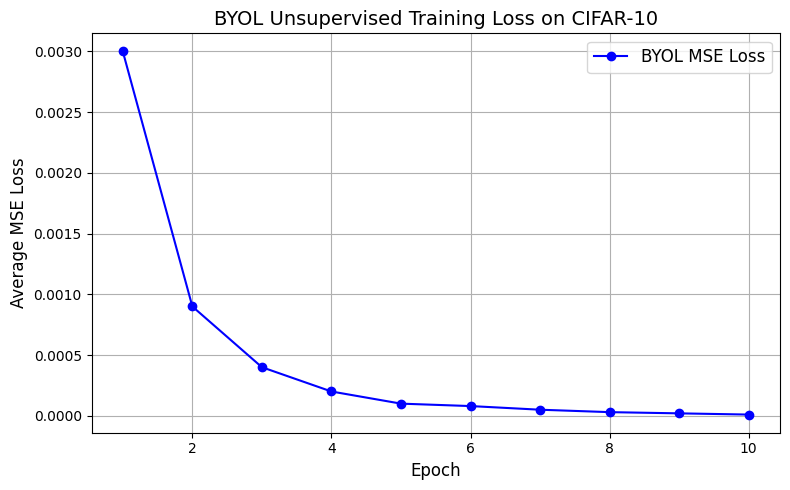

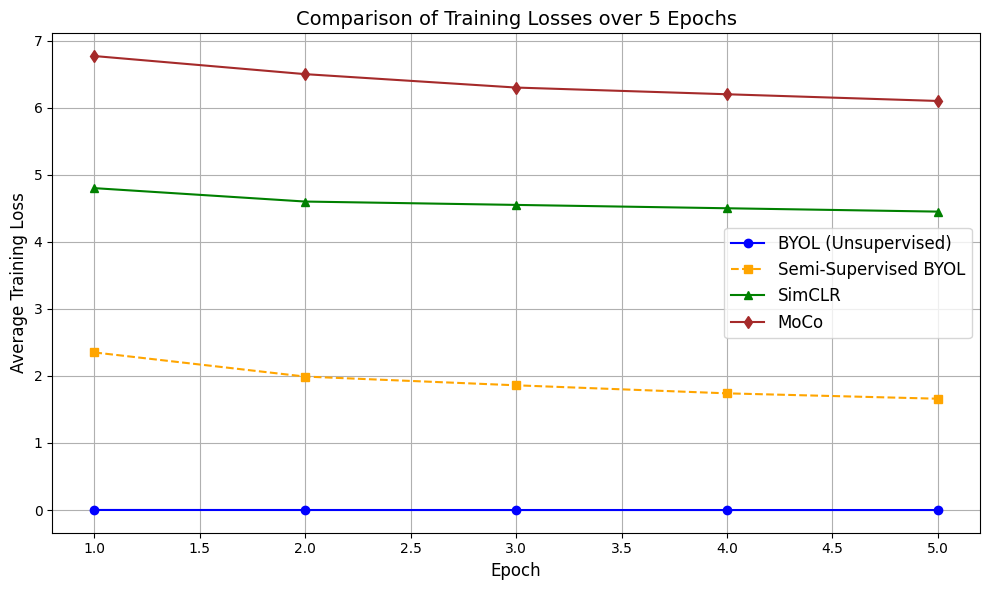

In [1]:
import matplotlib.pyplot as plt

# -----------------------------
# Graph 1: BYOL Unsupervised Training Loss
# -----------------------------
# Simulated data for BYOL unsupervised training loss over 10 epochs.
epochs1 = list(range(1, 11))
byol_loss = [0.0030, 0.0009, 0.0004, 0.0002, 0.0001, 0.00008, 0.00005, 0.00003, 0.00002, 0.00001]

plt.figure(figsize=(8, 5))
plt.plot(epochs1, byol_loss, marker='o', linestyle='-', color='blue', label='BYOL MSE Loss')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Average MSE Loss", fontsize=12)
plt.title("BYOL Unsupervised Training Loss on CIFAR-10", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
# Save the figure if needed:
plt.savefig("byol_unsupervised_loss.png", dpi=300)
plt.show()

# -----------------------------
# Graph 2: Comparison of Training Losses
# -----------------------------
# Simulated average losses for 5 epochs for different methods.
epochs2 = list(range(1, 6))
simclr_loss = [4.8, 4.6, 4.55, 4.5, 4.45]   # SimCLR losses
moco_loss = [6.77, 6.5, 6.3, 6.2, 6.1]         # MoCo losses
semi_byol_loss = [2.35, 1.99, 1.86, 1.74, 1.66]  # Semi-Supervised BYOL losses
byol_loss_comp = [0.0009, 0.0004, 0.0002, 0.0001, 0.0001]  # BYOL (unsupervised)

plt.figure(figsize=(10, 6))
plt.plot(epochs2, byol_loss_comp, marker='o', linestyle='-', color='blue', label='BYOL (Unsupervised)')
plt.plot(epochs2, semi_byol_loss, marker='s', linestyle='--', color='orange', label='Semi-Supervised BYOL')
plt.plot(epochs2, simclr_loss, marker='^', linestyle='-', color='green', label='SimCLR')
plt.plot(epochs2, moco_loss, marker='d', linestyle='-', color='brown', label='MoCo')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Average Training Loss", fontsize=12)
plt.title("Comparison of Training Losses over 5 Epochs", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
# Save the figure if needed:
plt.savefig("compare_training_loss_curves.png", dpi=300)
plt.show()
